# Detecting Biased Scores - Investigating Fandango Movie Ratings



## Introduction
---

In October 2015, Walt Hickey, a journalist associated to the [FiveThirtyEight](https://fivethirtyeight.com/features/fandango-movies-ratings/) media outlet, found evidence that movie ratings at [Fandango](https://www.fandango.com/) were biased; according to the author, this bias was achieved mainly through how Fandango decided to round the final ratings presented to the public, e.g. if a movie was rated initially with 4.1 stars out of 5, it would be rated in a final score with 4.5 stars in the final scale, instead of 4. This method resulted in the overall inflation of the selection of movies reviewed by this platform. Fandango replied to the article, promising to solve that inconsistency. Some years have passed since then, so it may be interesting to determine whether we can still verify some sort of bias from Fandango ratings, or has the company really attempted to solve the issue. To support our analysis, we'll be comparing Fandango ratings with analogous data from other popular online movie review platforms - IMDB, Metacritic and Rotten Tomatoes.



## The Data
---

To perform this task, we'll need information about the Fandango's movie ratings from before and after the FiveThirtyEight's release of the exposing article, in order to conduct a comparison. For the 'before' we resort to the [Walt Hickey's repository](https://github.com/fivethirtyeight/data/tree/master/fandango) on GitHub, while for the 'after', we kindly thank the Dataquest team for providing analogous [data](https://github.com/mircealex/Movie_ratings_2016_17) regarding movie ratings released in 2016 and 2017. 

In [1]:
# Importing libraries.
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Walt Hickey's initial data set.
ratings_bfr = pd.read_csv('fandango_score_comparison.csv').rename(columns={'FILM':'MOVIE'})

# Dataquest's 2016-17 data set.
ratings_aft = pd.read_csv('movie_ratings_16_17.csv')

### First Assessment Of The Data Sets

Data set description (these are the first 7 columns, full description in Annex I):

From `ratings_bfr`:

| **Column**                    | **Definition**|
| ----------------------------- |---------------|
| `FILM`                          | The film in question.|
| `RottenTomatoes`                | The Rotten Tomatoes Tomatometer score for the film.|
| `RottenTomatoes_User`          | The Rotten Tomatoes user score for the film.|
| `Metacritic`                    | The Metacritic critic score for the film.|
| `Metacritic_User`              | The Metacritic user score for the film.|
| `IMDB`                          | The IMDb user score for the film.|
| `Fandango_Stars`               | The number of stars the film had on its Fandango movie page.|
| ...        | ... |


From `ratings_aft`:

|Column              |Description                                                                                                                      |
|--------------------|-------------|
| `movie`         | The name of the movie.                                                                   |
| `year`          | The release year of the movie.                                                           |
| `metascore`     | The Metacritic rating of the movie (the "metascore" - critic score).                     |
| `imdb`          | The IMDB rating of the movie (user score).                                               |
| `tmeter`        | The Rotten Tomatoes rating of the movie (the "tomatometer" - critic score).              |
| `audience`      | The Rotten Tomatoes rating of the movie (user score).                                    |
| `fandango`      | The Fandango rating of the movie (user score).                                           |
| ...        | ... |


To generalize about Fandango's rating system as whole, it is necessary to check whether both data sets are comprehensive, i.e. are they a good representation of all movies rated in this platform? From the statements below, we know that both data sets were cleaned of some movie ratings, using different criteria:

- 'before' data set (by Walt Hickey): ['contains every movie (...) at least 30 fan reviews on Fandango'.](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md)


- 'after' data set (by Alex Olteanu): ['I have collected ratings for some of the most voted and reviewed movies in 2016 and 2017.'](https://www.freecodecamp.org/news/whose-reviews-should-you-trust-imdb-rotten-tomatoes-metacritic-or-fandango-7d1010c6cf19/)

Since both data sets account for movies with a reasonable number of reviews, we can assume they are somewhat comparable.


#### Number of rows, columns and data types:
- as we can see, for all columns, the number of non-null values always matches the number of entries/rows given by the `RangeIndex`, meaning that we don't have any missing values in our data sets. 

In [3]:
ratings_bfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MOVIE                       146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

In [4]:
ratings_aft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         214 non-null    object 
 1   year          214 non-null    int64  
 2   metascore     214 non-null    int64  
 3   imdb          214 non-null    float64
 4   tmeter        214 non-null    int64  
 5   audience      214 non-null    int64  
 6   fandango      214 non-null    float64
 7   n_metascore   214 non-null    float64
 8   n_imdb        214 non-null    float64
 9   n_tmeter      214 non-null    float64
 10  n_audience    214 non-null    float64
 11  nr_metascore  214 non-null    float64
 12  nr_imdb       214 non-null    float64
 13  nr_tmeter     214 non-null    float64
 14  nr_audience   214 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


A quick look at the DataFrames by inspecting the first row: 

In [5]:
ratings_bfr.iloc[0, :]

MOVIE                         Avengers: Age of Ultron (2015)
RottenTomatoes                                            74
RottenTomatoes_User                                       86
Metacritic                                                66
Metacritic_User                                          7.1
IMDB                                                     7.8
Fandango_Stars                                           5.0
Fandango_Ratingvalue                                     4.5
RT_norm                                                  3.7
RT_user_norm                                             4.3
Metacritic_norm                                          3.3
Metacritic_user_nom                                     3.55
IMDB_norm                                                3.9
RT_norm_round                                            3.5
RT_user_norm_round                                       4.5
Metacritic_norm_round                                    3.5
Metacritic_user_norm_rou

In [6]:
ratings_aft.iloc[0, :]

movie           10 Cloverfield Lane
year                           2016
metascore                        76
imdb                            7.2
tmeter                           90
audience                         79
fandango                        3.5
n_metascore                     3.8
n_imdb                          3.6
n_tmeter                        4.5
n_audience                     3.95
nr_metascore                    4.0
nr_imdb                         3.5
nr_tmeter                       4.5
nr_audience                     4.0
Name: 0, dtype: object

### Quick clean-up of the `Movie` column in `ratings_bfr`

As we can see the column `MOVIE` contains both the title of the movie and the year of release. Below we separate these two elements into separate columns.

In [7]:
ratings_bfr_MOVIE_splitted = ratings_bfr['MOVIE'].str.split(pat=' \(', expand=True)

ratings_bfr_MOVIE_splitted = ratings_bfr_MOVIE_splitted.rename(columns={0:'MOVIE', 1:'YEAR'})

ratings_bfr_MOVIE_splitted['YEAR'] = ratings_bfr_MOVIE_splitted['YEAR'].str.replace('\)', '', regex=True)

ratings_bfr_MOVIE_splitted = ratings_bfr_MOVIE_splitted.astype({'YEAR':'int'})

# Replacing the old `MOVIE` column in `ratings_bfr` by  the columns in`ratings_bfr_MOVIE_splitted`.
ratings_bfr['MOVIE'] = ratings_bfr_MOVIE_splitted['MOVIE']

ratings_bfr = ratings_bfr.join(ratings_bfr_MOVIE_splitted['YEAR'])

# Checking changes. 
ratings_bfr.loc[:3, ['MOVIE', 'YEAR']]

,MOVIE,YEAR
0,Avengers: Age of Ultron,2015
1,Cinderella,2015
2,Ant-Man,2015
3,Do You Believe?,2015


## Analysis Of Frequency Distributions - A Visual Exploration
---

Here we try to find out whether there is a substantial difference between the Fandango user ratings' distributions before and after the bias has been exposed. To do that, we resort to kernel density plots in order to compare the frequency distributions. The comparison will be between:
- Fandango ratings and a simulated normally distributed array.
- Fandango ratings over different years.
- Fandango ratings against other movie review platforms.

The fundamental premise is that an unbiased array of ratings should have a symmetrical frequency distribution around the mean, which in this case should be 2.5 stars. We should also expect values to be spread across the whole range spectrum, from 0 to 5. 

We start with a year vs year frame of comparison, isolating the 2015 and 2016 values from `ratings_bfr` and `ratings_aft` respectively:

In [8]:
rts_2015 = ratings_bfr[ratings_bfr['YEAR']==2015].copy()

rts_2016 = ratings_aft[ratings_aft['year']==2016].copy()

print('Number of movies in 2015:', rts_2015.shape[0])
print('Number of movies in 2016:', rts_2016.shape[0])

Number of movies in 2015: 129
Number of movies in 2016: 191


Descriptive statistics of Fandango ratings in 2015 and 2016.

In [9]:
rts_2015['Fandango_Stars'].describe()

count    129.000000
mean       4.085271
std        0.538096
min        3.000000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: Fandango_Stars, dtype: float64

In [10]:
rts_2016['fandango'].describe()

count    191.000000
mean       3.887435
std        0.509540
min        2.500000
25%        3.500000
50%        4.000000
75%        4.250000
max        5.000000
Name: fandango, dtype: float64

Looking at the descriptive statistics above, we can tell that values/ratings are generally inflated in both cases. In a range from 0 to 5, the mean plus one-standard-deviation should sum up to approx. 3.5 (stars), and in a normal distribution, values equal and below that threshold should account for approx. 84% of the total observations. As we can see, values equal and below 3.5 stars account only for 25% of the total, meaning that 75% of all values surpass the mean plus one standard-deviation (when it should only be around 16%).

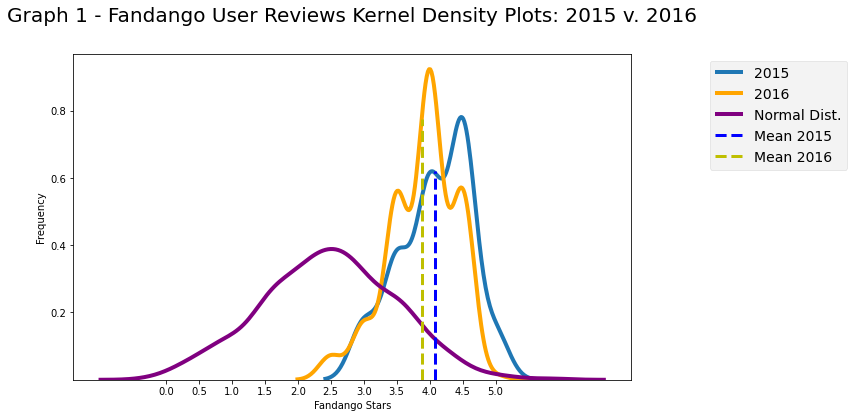

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# Setting the 'fivethirtyeight' custom style.
plt.style.use('fivethirtyeight')

ax.set_title('Graph 1 - Fandango User Reviews Kernel Density Plots: 2015 v. 2016',
             size=20,
             y=1.08)

# Plotting the two lines.
sns.kdeplot(data=rts_2015['Fandango_Stars'],
            label='2015')


sns.kdeplot(data=rts_2016['fandango'],
            label='2016',
            color='orange')  # 'fandango' is equivelent to 'Fandango_Stars'


sns.kdeplot(data=np.random.normal(loc=2.5, scale=1.0, size=1000),
            label='Normal Dist.',
            color='purple')  # Normal distribution 


# `rts_2015['Fandango_Stars']` mean.
ax.axvline(x=rts_2015['Fandango_Stars'].mean(),
           ymin=0,
           ymax=0.64,
           linewidth=3,
           c='b',
           ls='--',
           label='Mean 2015')

# `rts_2016['fandango']` mean
ax.axvline(ymin=0,
           ymax=0.8,
           x=rts_2016['fandango'].mean(),
           linewidth=3,
           color='y',
           ls='--',
           label='Mean 2016')


# Ticks.
ax.set_xticks(np.arange(0, 5.5, 0.5))

# Code line to hide the first value - '0', in the y ticks.
plt.yticks(np.arange(0.2, 1.0, 0.2))


# Labels.
ax.set_ylabel('Frequency', position=(0.2, 0.5))

ax.set_xlabel('Fandango Stars')


# Others.
plt.legend(bbox_to_anchor=(1.4, 1))


plt.show()

From Graph 1 (above) we can assess: 

- The purple line is a random process that simulates a normal distribution with 1000 observations, centered around the mean at  (approx.) 2.5; when comparing it with the ratings' distributions, we can see that these lines may resemble the shape of a normal distribution, but are completely off center and both have high kurtosis (high concentration of values around a shorter magnitude range), which visibly shortens both left and right tails while augments the peaks' height.  


- The rating system ranges from 0 to 5 stars, therefore it is expected for a normal distribution that the mean, mode and median to be equally centered at 2.5, which we can see it does not apply in this case. In both cases, means are at very high values (4.08 in 2015 and 3.88 in 2016).


- Also in both years, we can notice that the peak frequency is at the right side of the mean (more pronounced in 2015 than in 2016), which causes these distributions to be negatively skewed (longer and slimmer left tail).

### Descriptive Statistics - Divergence Between Mode, Mean And The Median

According to statistical theory, a distribution of values becomes closer to a normal distribution when the mean, the median and the mode converge; inversely, if the mean and the mode diverge more and more from the median, we tend to have an increasingly skewed distribution. 

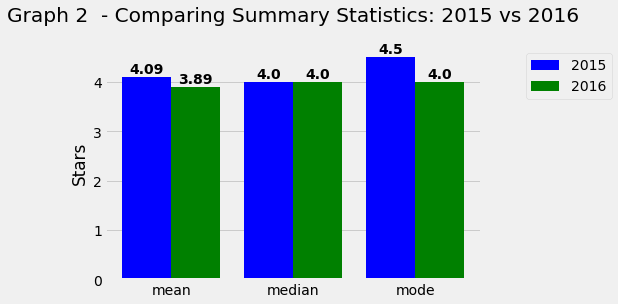

In [12]:
# Support DataFrame with the mean, median and mode for 2015 and 2016 series.
stats_15_dic = {'mean':round(rts_2015['Fandango_Stars'].mean(), 2),
            'median':rts_2015['Fandango_Stars'].median(),
            'mode':rts_2015['Fandango_Stars'].mode()}

stats_16_dic = {'mean':round(rts_2016['fandango'].mean(), 2),
            'median':rts_2016['fandango'].median(),
            'mode':rts_2016['fandango'].mode()}

stats_15 = pd.DataFrame(stats_15_dic).set_index(np.array([2015]))

stats_16 = pd.DataFrame(stats_16_dic).set_index(np.array([2016]))

stats = pd.concat([stats_15, stats_16])

# Bar chart based on `stats`.
fig, ax = plt.subplots()


ax.set_title('Graph 2  - Comparing Summary Statistics: 2015 vs 2016', y=1.08)

labels = stats.columns

x = np.arange(len(labels))  # the label locations

width = 0.4  # the width of the bars


# Plot in pairs.
bars_2015 = ax.bar(x - width/2, stats.loc[2015, :], width, label='2015', color='b')
bars_2016 = ax.bar(x + width/2, stats.loc[2016, :], width, label='2016', color='g')


# Values over bars.

# 2015.
for index, bar in enumerate(bars_2015):
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    plt.text(x+width/2,
             y+height*1.02,
             stats.iloc[0, index], # 2015 is row 0
             ha='center',
             weight='bold')

# 2016.
for index, bar in enumerate(bars_2016):
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    plt.text(x+width/2,
             y+height*1.02,
             stats.iloc[1, index], # 2016 is row 1
             ha='center',
             weight='bold')

                               
# Ticks and labels.
ax.set_ylabel('Stars')
ax.set_xticks(range(0, len(stats.columns)))
ax.set_xticklabels(labels)


# Placing the legend next to the graph avoiding the overlapping.
plt.legend(bbox_to_anchor=(1.1, 1))

ax.grid(axis='x')

plt.show()
                 

Observing Graph 2, we see that 2015 values for the mean and mode are higher and farther away from the median, whilst in the 2016 values, all statistics converge to 4 (stars), re-enforcing the idea that the ratings in 2015 are exceptionally positively inflated, while ratings in 2016 still look inflated, albeit to a less extent. 

## Comparing Fandango  Ratings With IMDB, Metacritic and Rotten Tomatoes
---

Besides comparing Fandango against it self, we can also compare the distribution of user ratings across the aforementioned group of popular platforms, throughout 2015 and 2016. `ratings_bfr` and `ratings_aft` contain a normalized version of the movie ratings of each platform, i.e. these ratings have been standardized to resemble the Fandango 0 to 5 star rating scale.    

This time around, we'll be analyzing all movies released in 2014-15 and 2016-17 separately, instead of a year over year comparison.

The normalized ratings in both data sets:

In [13]:
ratings_bfr.loc[:, ratings_bfr.columns.str.contains('round')].head()

,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round
0,3.5,4.5,3.5,3.5,4.0
1,4.5,4.0,3.5,4.0,3.5
2,4.0,4.5,3.0,4.0,4.0
3,1.0,4.0,1.0,2.5,2.5
4,0.5,1.5,1.5,1.5,2.5


In [14]:
ratings_aft.loc[:5, ['n_imdb', 'fandango', 'n_metascore', 'n_audience']]

,n_imdb,fandango,n_metascore,n_audience
0,3.60,3.5,3.80,3.95
1,3.65,4.5,2.40,4.15
2,3.30,3.0,2.35,2.35
3,2.60,4.5,2.15,3.80
4,3.05,3.0,2.90,2.85
5,3.75,4.0,3.80,4.20


Storing the normalized columns into support DataFrames - `ratings_norm_bfr` and `ratings_norm_aft`, in order to make a new battery of density kernel plots.

Note: Rotten Tomatoes has two normalized ratings in the `ratings_bfr` data set - `RT_norm_round` and `RT_user_norm_round`; we'll use the latter, which is the user score.

In [15]:
# New 'before' DataFrame with solely the normalized ratings columns.
ratings_norm_bfr = ratings_bfr.loc[:, ratings_bfr.columns.str.contains('(?:user_norm_round|Fandango_Stars|IMDB_norm_round)')].copy()

ratings_norm_bfr = ratings_norm_bfr.rename(columns={'IMDB_norm_round':'IMDB',
                                                    'Fandango_Stars':'Fandango',
                                                    'Metacritic_user_norm_round':'Metacritic',
                                                    'RT_user_norm_round':'Rotten Tomatoes'
                                                    })

ratings_norm_bfr = ratings_norm_bfr.reindex(columns=sorted(ratings_norm_bfr.columns))



# New 'after' DataFrame with solely the normalized ratings columns.
# 'n_audience' is the Rotten Tomatoes normalized user score.
ratings_norm_aft = ratings_aft.loc[:, ['n_imdb', 'fandango', 'n_metascore', 'n_audience']].copy()

ratings_norm_aft = ratings_norm_aft.rename(columns={'n_imdb':'IMDB',
                                                    'fandango':'Fandango',
                                                    'n_metascore':'Metacritic',
                                                    'n_audience':'Rotten Tomatoes'
                                                    })


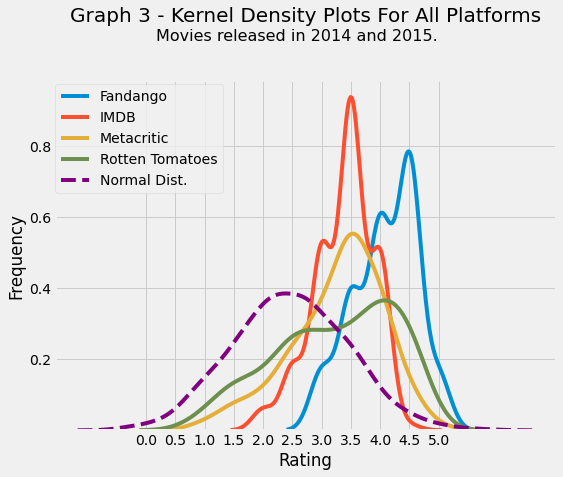

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Setting the 'fivethirtyeight' custom style.
plt.style.use('fivethirtyeight')
  
    
# Tiles.
ax.set_title('Graph 3 - Kernel Density Plots For All Platforms', 
             size=20,
             y=1.15)

fig.suptitle('Movies released in 2014 and 2015.', 
             size=16,
             y=1)


# Plotting the lines for all platforms.
for col in ratings_norm_bfr.columns:
    sns.kdeplot(data=ratings_norm_bfr[col], 
                label=col)

    
# Normal distribution plot.   
sns.kdeplot(data=np.random.normal(loc=2.5, scale=1.0, size=1000),
            label='Normal Dist.',
            color='purple',
            ls='--')   
    
    
# Ticks.
ax.set_xticks(np.arange(0, 5.5, 0.5))



# Code line to hide the first value - '0', in the y ticks.
plt.yticks(np.arange(0.2, 1.0, 0.2))


# Labels.
ax.set_ylabel('Frequency', position=(0.2, 0.5))

ax.set_xlabel('Rating')



# Legend setting.

plt.legend(bbox_to_anchor=(0.35, 1.01))


plt.show()


Descriptive statistics for all platform ratings: 2014-15. 


In [17]:
ratings_norm_bfr.describe().round(2)

,Fandango,IMDB,Metacritic,Rotten Tomatoes
count,146.00,146.00,146.00,146.00
mean,4.09,3.38,3.27,3.23
std,0.54,0.50,0.79,1.01
min,3.00,2.00,1.00,1.00
25%,3.50,3.00,3.00,2.50
50%,4.00,3.50,3.50,3.50
75%,4.50,3.50,4.00,4.00
max,5.00,4.50,5.00,4.50


According to the Graph 3 and the table above, we can see that:
- None of the ratings in the various the platforms is actually close to resemble a normally distributed series (the dashed purple line is a simulation of normally distributed series, similar to the one used in Graph 1).


- Fandango distribution seems the most uneven of the group, with 50% of the values being equal or over 4 stars. 


- Metacritic seems to be the distribution which resembles more a normal distribution, although it has a high mean, 3.27, compared with the expected 2.5; and also has a higher frequency peak (mode) beyond 50% of the total values, when a normal distribution has its peak frequency around 40%. Metacritic is also the only distribution where values span over an extended range, from 1 up to 5 stars.


- IMDB distribution seems to have a very similar shape to Fandango's distribution in 2016 (see Graph 1 and Graph 4).


- Rotten Tomatoes distribution has the lowest average rating, 3.23, but still shows a noticeable negative skewness. 
    

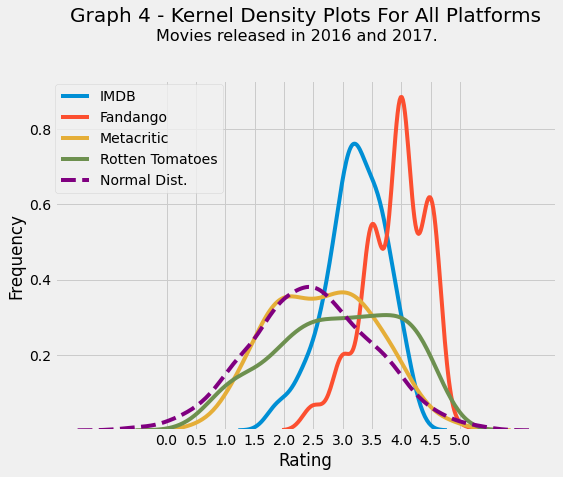

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

# Setting the 'fivethirtyeight' custom style.
plt.style.use('fivethirtyeight')
  
    
# Tiles.
ax.set_title('Graph 4 - Kernel Density Plots For All Platforms', 
             size=20,
             y=1.15)

fig.suptitle('Movies released in 2016 and 2017.', 
             size=16,
             y=1)


# Plotting the lines for all platforms.
for col in ratings_norm_aft.columns:
    sns.kdeplot(data=ratings_norm_aft[col], 
                label=col)


# Normal distribution plot.   
sns.kdeplot(data=np.random.normal(loc=2.5, scale=1.0, size=1000),
            label='Normal Dist.',
            color='purple',
            ls='--')      

# Ticks.
ax.set_xticks(np.arange(0, 5.5, 0.5))



# Code line to hide the first value - '0', in the y ticks.
plt.yticks(np.arange(0.2, 1.0, 0.2))


# Labels.
ax.set_ylabel('Frequency', position=(0.2, 0.5))

ax.set_xlabel('Rating')



# Legend setting.

plt.legend(bbox_to_anchor=(0.35, 1.01))


plt.show()

Descriptive statistics for all platform ratings: 2016-17. 

In [19]:
ratings_norm_aft.describe().round(2)

,IMDB,Fandango,Metacritic,Rotten Tomatoes
count,214.00,214.00,214.00,214.00
mean,3.22,3.89,2.66,2.93
std,0.52,0.52,0.89,1.06
min,1.75,2.50,0.55,0.55
25%,2.91,3.50,1.95,2.16
50%,3.25,4.00,2.68,3.02
75%,3.60,4.50,3.30,3.84
max,4.25,5.00,4.95,4.65


In Graph 4 we see that the Metacritic's is by far the distribution that most resembles a normal distribution, having a mean and a median very close to 2.5 (see table above). On the other hand, Fandango has its distribution the farthest away from a normal distribution shape, having also the highest average rating of the group - 3.89 stars, and a median of 4 stars.

#### Quick normal distribution test battery for the `ratings_norm_aft` DataFrame.

Since Metacritic visually shows a distribution of ratings close to normality, let's perform two tests where the null hypothesis states: 'the data was drawn from a normal distribution'; these are:
-  [Shapiro-Wilk test for normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html?highlight=shapiro)
- [Normality test based on D’Agostino and Pearson’s test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)

For both tests, if the p-value of the test statistic is under our threshold, say 5%, we can reject the null hypothesis that the series in question has a normal distribution.

In [20]:
from scipy.stats import shapiro
from scipy.stats import normaltest as dagostino

for col in ratings_norm_aft.columns:
    shapiro_stat, shapiro_p_value = shapiro(ratings_norm_aft[col])
    dagostino_stat, dagostino_p_value = dagostino(ratings_norm_aft[col])
    shapiro_stat = round(shapiro_stat, 3)
    shapiro_p_value = round(shapiro_p_value, 3)
    dagostino_stat = round(dagostino_stat, 3)
    dagostino_p_value = round(dagostino_p_value, 3)
    
    print(f'{col}:')
    print(f'{shapiro_stat = }, {shapiro_p_value = }')
    print(f'{dagostino_stat = }, {dagostino_p_value = }')
    print('\n')

IMDB:
shapiro_stat = 0.98, shapiro_p_value = 0.004
dagostino_stat = 7.418, dagostino_p_value = 0.025


Fandango:
shapiro_stat = 0.883, shapiro_p_value = 0.0
dagostino_stat = 12.614, dagostino_p_value = 0.002


Metacritic:
shapiro_stat = 0.989, shapiro_p_value = 0.116
dagostino_stat = 7.816, dagostino_p_value = 0.02


Rotten Tomatoes:
shapiro_stat = 0.966, shapiro_p_value = 0.0
dagostino_stat = 26.404, dagostino_p_value = 0.0




Looking at the test results, we can see that besides Metacritic, we can reject normality for all series/ratings. For Metacritic, we cannot reject the null hypothesis when using the Shapiro-Wilk test (p-value=0.115), whilst we do so, if we refer to the D'Agostino-Pearson based test (p-value=0.02). In any case, we can confirm that Metacritic is the review platform closest to be unbiased, if we take the resemblance of the ratings distribution to a normal distribution as the defining criterion for unbiasedness. 


## Conclusion
---
Given the analysis we conducted here, one can see that all the evidence points towards a dissipation of the excessive number of positive ratings observed at Fandango prior to 2016, at least to a certain extent. This maybe the direct result of Fandango's decision to act upon the rounding-up caveat exposed by the Walt Hickey's article. Still to be explained by Fandango is why there aren't movies with a rating lower than 2.5 stars (2016-2017 ratings) in their sample. Comparing to other movie review platform ratings, we can also conclude that Fandango presents the most inflated values, without us having a reason for that fact. 

Another interesting fact stems from the fact that Metacritic ratings of 2016-17 resemble somewhat a normal distribution, where average films with a rating around 2.5 stars (normalized to fit a 0 to 5 rating) should be the most frequent movies, while both bad and good films should be increasingly rarer as they tend towards to either mindlessness or excellency, respectively.  

### Annex I
---

Full description of `ratings_bfr`:

| **Column**                    | **Definition**|
| ----------------------------- |---------------|
| FILM                          | The film in question.|
| RottenTomatoes                | The Rotten Tomatoes Tomatometer score for the film.|
| RottenTomatoes_User          | The Rotten Tomatoes user score for the film.|
| Metacritic                    | The Metacritic critic score for the film.|
| Metacritic_User              | The Metacritic user score for the film.|
| IMDB                          | The IMDb user score for the film.|
| Fandango_Stars               | The number of stars the film had on its Fandango movie page.|
| Fandango_Ratingvalue         | The Fandango ratingValue for the film, as pulled from the HTML of each page. This is the actual average score the movie obtained. |
| RT_norm                      | The Rotten Tomatoes Tomatometer score for the film , normalized to a 0 to 5 point system.|
| RT_user_norm                | The Rotten Tomatoes user score for the film , normalized to a 0 to 5 point system.|
| Metacritic_norm              | The Metacritic critic score for the film, normalized to a 0 to 5 point system.|
| Metacritic_user_nom         | The Metacritic user score for the film, normalized to a 0 to 5 point system.|
| IMDB_norm                    | The IMDb user score for the film, normalized to a 0 to 5 point system.|
| RT_norm_round               | The Rotten Tomatoes Tomatometer score for the film , normalized to a 0 to 5 point system and rounded to the nearest half-star.|
| RT_user_norm_round         | The Rotten Tomatoes user score for the film , normalized to a 0 to 5 point system and rounded to the nearest half-star.|
| Metacritic_norm_round       | The Metacritic critic score for the film, normalized to a 0 to 5 point system and rounded to the nearest half-star.|
| Metacritic_user_norm_round | The Metacritic user score for the film, normalized to a 0 to 5 point system and rounded to the nearest half-star.|
| IMDB_norm_round             | The IMDb user score for the film, normalized to a 0 to 5 point system and rounded to the nearest half-star.|
| Metacritic_user_vote_count | The number of user votes the film had on Metacritic.|
| IMDB_user_vote_count       | The number of user votes the film had on IMDb.|
| Fandango_votes               | The number of user votes the film had on Fandango.|
| Fandango_Difference          | The difference between the presented Fandango_Stars and the actual Fandango_Ratingvalue.|

Full description of `ratings_aft`:

| **Column**    | **Description**                                                                         |
| ------------- | --------------------------------------------------------------------------------------- |
| movie         | the name of the movie                                                                   |
| year          | the release year of the movie                                                           |
| metascore     | the Metacritic rating of the movie (the "metascore" - critic score)                     |
| imdb          | the IMDB rating of the movie (user score)                                               |
| tmeter        | the Rotten Tomatoes rating of the movie (the "tomatometer" - critic score)              |
| audience      | the Rotten Tomatoes rating of the movie (user score)                                    |
| fandango      | the Fandango rating of the movie (user score)                                           |
| n_metascore  | the metascore normalized to a 0-5 scale                                                 |
| n_imdb       | the IMDB rating normalized to a 0-5 scale                                               |
| n_tmeter     | the tomatometer normalized to a 0-5 scale                                               |
| n_audience   | the Rotten Tomatoes user score normalized to a 0-5 scale                                |
| nr_metascore | the metascore normalized to a 0-5 scale and rounded to the nearest 0.5                  |
| nr_imdb      | the IMDB rating normalized to a 0-5 scale and rounded to the nearest 0.5                |
| nr_tmeter    | the tomatometer normalized to a 0-5 scale and rounded to the nearest 0.5                |
| nr_audience  | the Rotten Tomatoes user score normalized to a 0-5 scale and rounded to the nearest 0.5 |

\[End of Project\]

\***